Stock Sentiment Analysis using Natural Language Processing

In [4]:
# Import key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

2025-01-06 09:37:41.445878: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Load the stock news data
stock_df = pd.read_csv("data/stock_sentiment.csv")

In [6]:
stock_df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [7]:
# Dataframe information
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [8]:
# Check for null values
stock_df.isnull().sum()

Text         0
Sentiment    0
dtype: int64

<Axes: ylabel='count'>

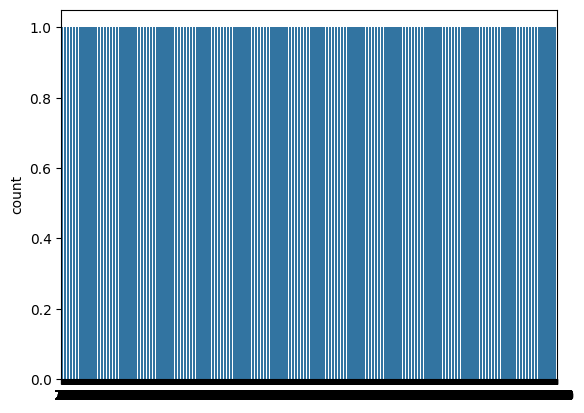

In [9]:
sns.countplot(stock_df['Sentiment'])

In [10]:
# Finding the number of unique values in a particular column
stock_df['Sentiment'].nunique()

2

Data Cleaning - Removing Punctuations

In [11]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
Test = '$I love AI & Machine learning!!'
Test_punc_removed = [char for char in Test if char not in string.punctuation]
Test_punc_removed_join = ''.join(Test_punc_removed)
Test_punc_removed_join

'I love AI  Machine learning'

In [13]:
Test = 'Good morning beautiful people :)... #I am having fun learning Finance with Python!!'
Test_punc_removed = [char for char in Test if char not in string.punctuation]
Test_punc_removed_join = ''.join(Test_punc_removed)
Test_punc_removed_join

'Good morning beautiful people  I am having fun learning Finance with Python'

In [14]:
# Defining a function to remove punctuations
def remove_punc(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)

    return Test_punc_removed_join

In [15]:
# Removing punctuations from our dataset 
stock_df['Text Without Punctuation'] = stock_df['Text'].apply(remove_punc)

In [16]:
stock_df

,Text,Sentiment,Text Without Punctuation
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...
3,MNTA Over 12.00,1,MNTA Over 1200
4,OI Over 21.37,1,OI Over 2137
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...


In [17]:
stock_df['Text'][2]

"user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service"

In [18]:
stock_df['Text Without Punctuation'][2]

'user Id be afraid to short AMZN  they are looking like a nearmonopoly in eBooks and infrastructureasaservice'

Data Cleaning - Removing Stopwords

In [19]:
# Download stopwords
nltk.download("stopwords")
stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/darshan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [20]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year', 'https'])
     

In [21]:
# Remove stopwords and remove short words (less than 2 characters)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) >= 3 and token not in stop_words:
            result.append(token)
            
    return result

In [22]:
# Apply pre-processing to the text column
stock_df['Text Without Punc & Stopwords'] = stock_df['Text Without Punctuation'].apply(preprocess)

In [23]:
stock_df['Text'][0]

'Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts'

In [24]:
stock_df['Text Without Punc & Stopwords'][0]

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts']

In [25]:
# Join the words into a string
stock_df['Text Without Punc & Stopwords Joined'] = stock_df['Text Without Punc & Stopwords'].apply(lambda x: " ".join(x))
     

Plotting Word Clouds

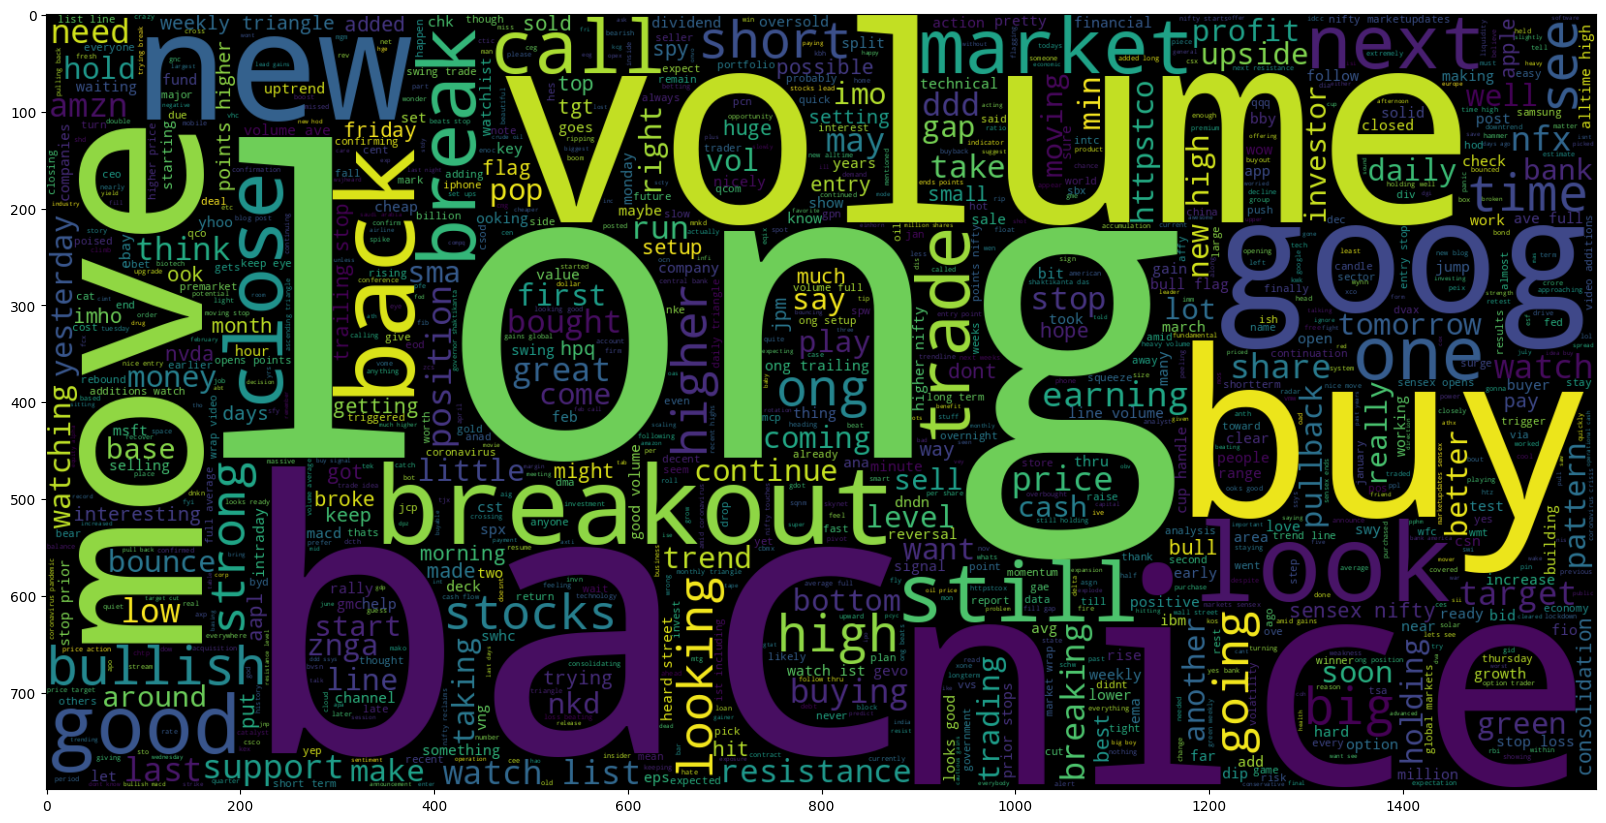

In [26]:
# Plotting the word cloud for text with positive sentiment
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(stock_df[stock_df['Sentiment'] == 1]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

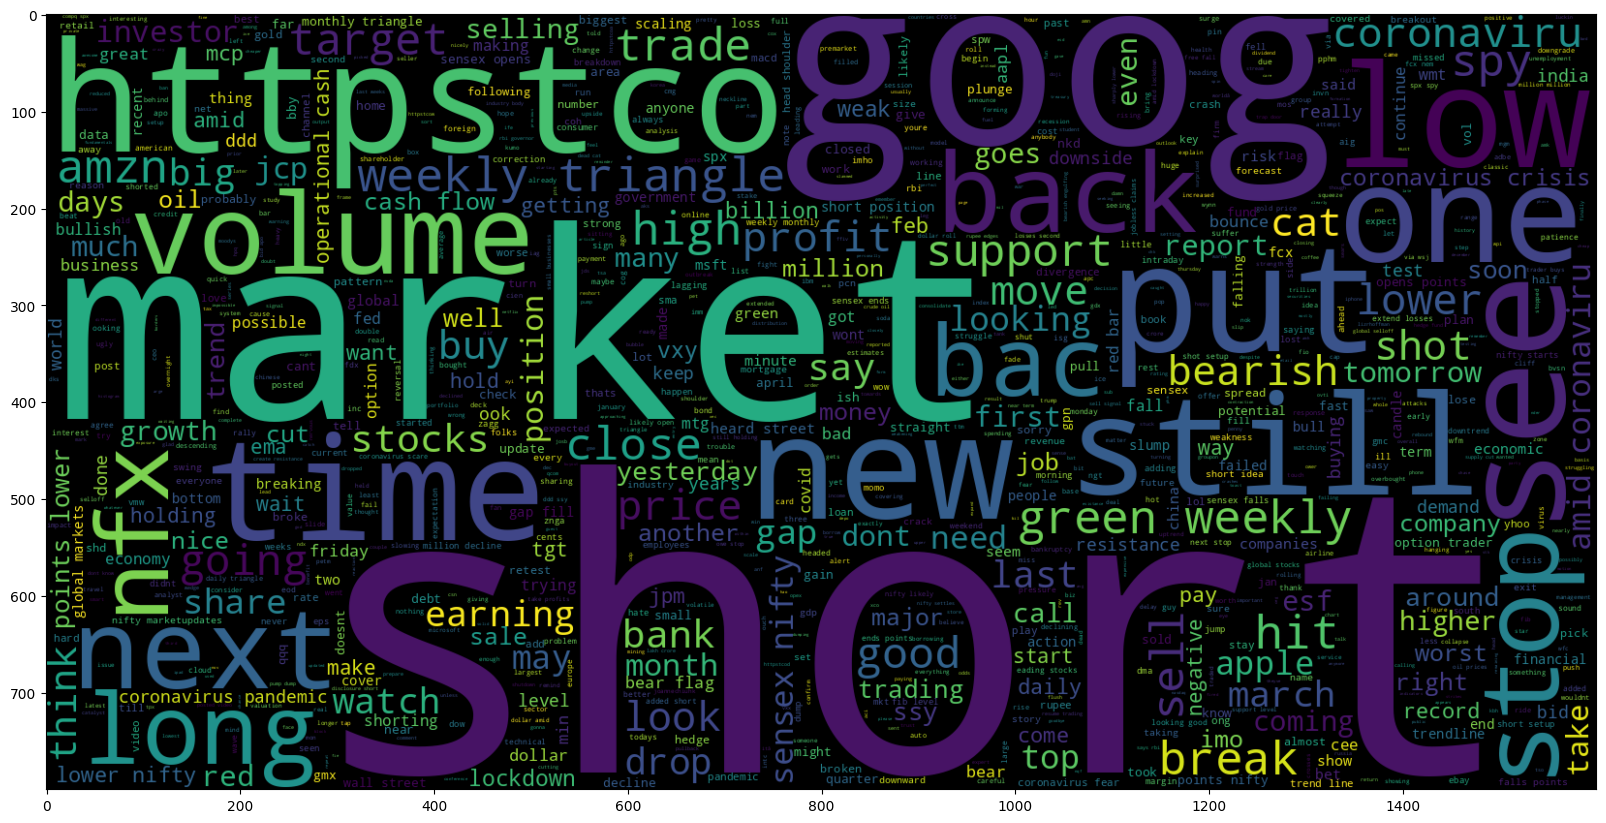

In [27]:
# Plotting the word cloud for text with negative sentiment
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000, width = 1600, height = 800 ).generate(" ".join(stock_df[stock_df['Sentiment'] == 0]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

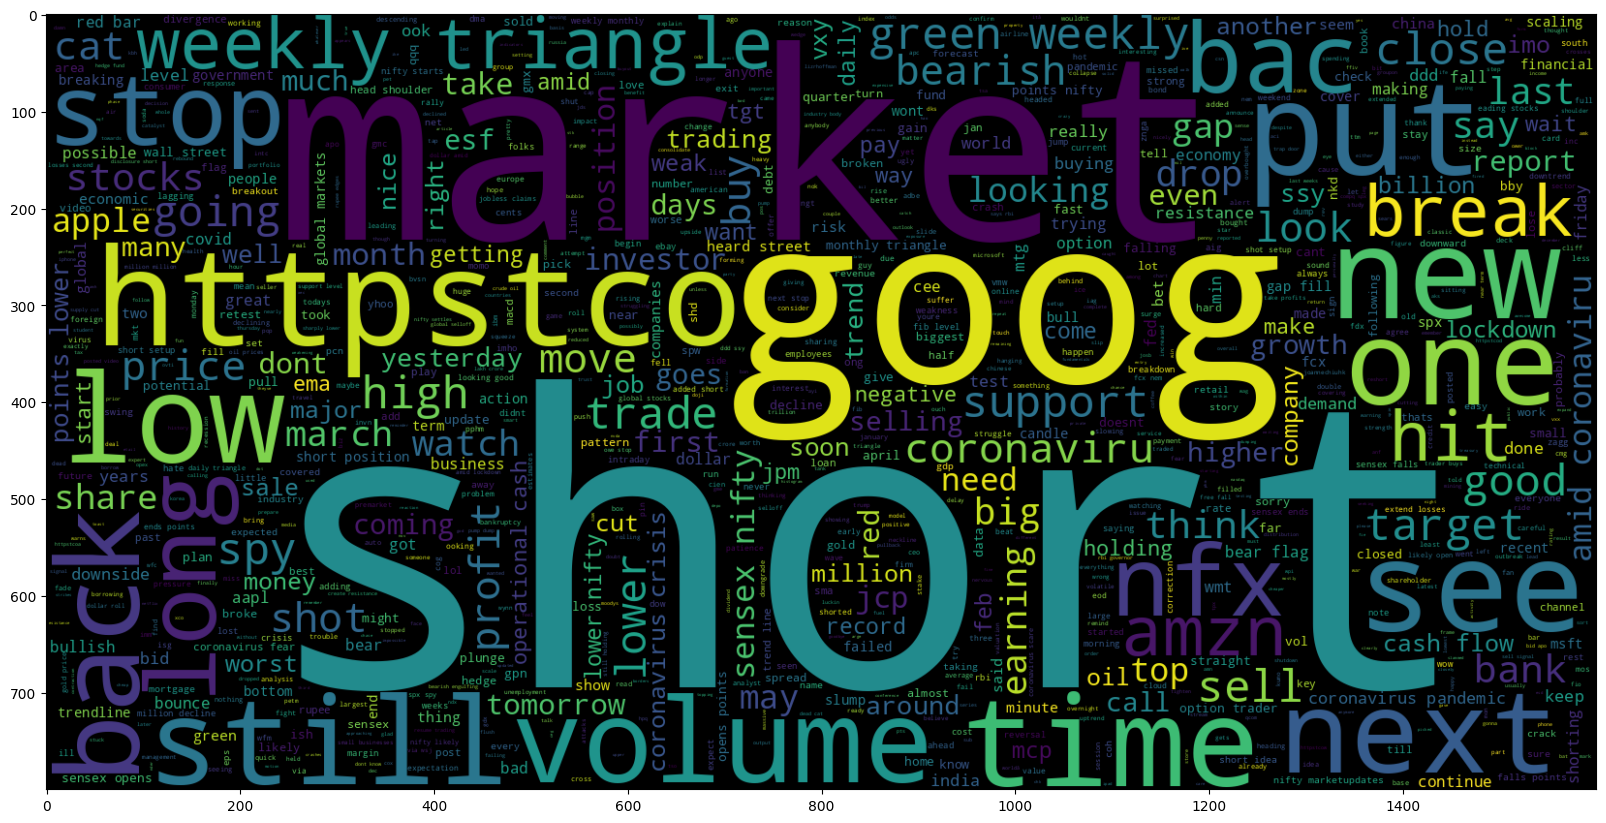

In [28]:
# Plotting the word cloud for text with negative sentiment
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000, width = 1600, height = 800 ).generate(" ".join(stock_df[stock_df['Sentiment'] == 0]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

Visualizing Cleaned Data

In [29]:
stock_df

,Text,Sentiment,Text Without Punctuation,Text Without Punc & Stopwords,Text Without Punc & Stopwords Joined
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz tra...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw...",movie return feageed indicator trades awesome
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[afraid, short, amzn, looking, like, nearmonop...",afraid short amzn looking like nearmonopoly eb...
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta],mnta
4,OI Over 21.37,1,OI Over 2137,[],
...,...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s...",industry body cii said discoms likely suffer n...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, investors, book, profits,...",gold prices slip investors book profits amid c...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri...",workers bajaj auto agreed wage cut period apri...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift...",sharemarket live sensex high points nifty test...


In [62]:
import nltk
nltk.download('punkt_tab') 

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/darshan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [63]:
from nltk.tokenize import word_tokenize

text = "This is a test sentence."
print(word_tokenize(text))


['This', 'is', 'a', 'test', 'sentence', '.']


In [64]:
# "word_tokenize" is used to break up a string into words
print(stock_df['Text Without Punc & Stopwords Joined'][0])
print(nltk.word_tokenize(stock_df['Text Without Punc & Stopwords Joined'][0]))

kickers watchlist xide tit soq pnk cpw bpz trade method method see prev posts
['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'trade', 'method', 'method', 'see', 'prev', 'posts']


In [65]:
# Obtain the maximum length of data in the document
# This will be later used when word embeddings are generated
maxlen = -1
for doc in stock_df['Text Without Punc & Stopwords Joined']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 20


In [66]:
tweets_length = [ len(nltk.word_tokenize(x)) for x in stock_df['Text Without Punc & Stopwords Joined'] ]
tweets_length

[14,
 6,
 7,
 1,
 0,
 1,
 8,
 13,
 8,
 4,
 10,
 18,
 8,
 8,
 11,
 5,
 12,
 10,
 12,
 4,
 6,
 5,
 2,
 5,
 3,
 10,
 3,
 3,
 9,
 6,
 8,
 10,
 8,
 3,
 10,
 11,
 4,
 8,
 11,
 10,
 10,
 7,
 9,
 8,
 4,
 10,
 8,
 7,
 7,
 9,
 10,
 10,
 8,
 2,
 14,
 12,
 9,
 8,
 1,
 14,
 7,
 11,
 5,
 13,
 6,
 6,
 7,
 6,
 6,
 10,
 9,
 4,
 10,
 13,
 16,
 6,
 9,
 6,
 2,
 11,
 5,
 4,
 9,
 11,
 16,
 4,
 9,
 5,
 6,
 2,
 1,
 5,
 9,
 4,
 7,
 6,
 7,
 10,
 1,
 3,
 9,
 4,
 16,
 8,
 10,
 11,
 18,
 6,
 7,
 13,
 12,
 9,
 3,
 3,
 10,
 10,
 8,
 6,
 8,
 5,
 5,
 8,
 9,
 15,
 3,
 5,
 9,
 18,
 13,
 11,
 3,
 1,
 1,
 2,
 7,
 12,
 12,
 8,
 8,
 10,
 9,
 10,
 15,
 8,
 9,
 9,
 12,
 10,
 6,
 10,
 13,
 4,
 11,
 8,
 15,
 13,
 8,
 12,
 5,
 5,
 3,
 7,
 2,
 4,
 10,
 5,
 6,
 10,
 6,
 16,
 9,
 6,
 5,
 10,
 9,
 10,
 8,
 2,
 10,
 9,
 10,
 12,
 7,
 10,
 7,
 3,
 6,
 5,
 9,
 9,
 4,
 6,
 5,
 4,
 4,
 8,
 10,
 8,
 8,
 13,
 9,
 7,
 10,
 12,
 8,
 6,
 5,
 3,
 10,
 11,
 6,
 9,
 10,
 13,
 10,
 7,
 12,
 7,
 11,
 10,
 4,
 4,
 3,
 10,
 2,
 9,
 10,
 15,
 12,
 10

In [67]:

# Plotting the distribution for the number of words in a text
fig = px.histogram(x = tweets_length, nbins = 50)
fig.show()

<Axes: ylabel='count'>

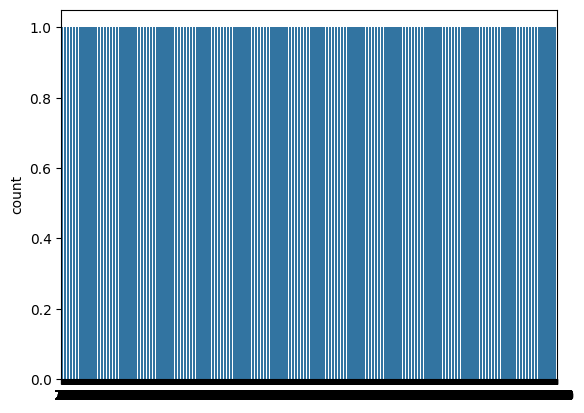

In [68]:
# Plotting the word count
sns.countplot(stock_df['Sentiment'])

Data Preparation by Tokenization & Padding

Tokenizer allows us to vectorize text corpus

Tokenization works by turning each text into a sequence of integers

In [69]:
stock_df

,Text,Sentiment,Text Without Punctuation,Text Without Punc & Stopwords,Text Without Punc & Stopwords Joined
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz tra...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw...",movie return feageed indicator trades awesome
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[afraid, short, amzn, looking, like, nearmonop...",afraid short amzn looking like nearmonopoly eb...
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta],mnta
4,OI Over 21.37,1,OI Over 2137,[],
...,...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s...",industry body cii said discoms likely suffer n...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, investors, book, profits,...",gold prices slip investors book profits amid c...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri...",workers bajaj auto agreed wage cut period apri...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift...",sharemarket live sensex high points nifty test...


In [70]:
# Obtain the total words present in the dataset
list_of_words = []
for i in stock_df['Text Without Punc & Stopwords']:
    for j in i:
        list_of_words.append(j)

In [71]:
list_of_words

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts',
 'movie',
 'return',
 'feageed',
 'indicator',
 'trades',
 'awesome',
 'afraid',
 'short',
 'amzn',
 'looking',
 'like',
 'nearmonopoly',
 'ebooks',
 'mnta',
 'pgnx',
 'current',
 'downtrend',
 'break',
 'otherwise',
 'shortterm',
 'correction',
 'medterm',
 'downtrend',
 'mondays',
 'relative',
 'weakness',
 'nyx',
 'win',
 'tie',
 'tap',
 'ice',
 'int',
 'bmc',
 'aon',
 'chk',
 'biib',
 'goog',
 'ower',
 'trend',
 'line',
 'channel',
 'test',
 'volume',
 'support',
 'watch',
 'tomorrow',
 'ong',
 'entry',
 'assuming',
 'fcx',
 'opens',
 'tomorrow',
 'trigger',
 'buy',
 'still',
 'much',
 'like',
 'setup',
 'really',
 'worries',
 'everyone',
 'expects',
 'market',
 'rally',
 'nowusually',
 'exact',
 'opposite',
 'happens',
 'every',
 'time',
 'shall',
 'see',
 'soon',
 'bac',
 'spx',
 'jpm',
 'gamcos',
 'arry',
 'haverty',
 'apple',
 'extremely',
 'chea

In [72]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

9268

In [73]:
# Splitting the data into test and train 
X = stock_df['Text Without Punc & Stopwords']
y = stock_df['Sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [74]:
X_train.shape

(5211,)

In [75]:
X_test.shape

(580,)

In [76]:
X_train

4800                       [insider, sells, worth, every]
1937    [amn, become, penny, company, continue, dilute...
323     [green, weekly, monthly, triangle, fwspdating,...
3044    [cvx, think, theres, good, point, enter, one, ...
2319    [nfx, sloping, lowermacd, cross, downnegative,...
                              ...                        
3014    [swy, watch, list, close, line, volume, full, ...
4567                        [goog, trying, short, around]
4512    [bullish, zagg, buy, invisibleshied, get, invi...
1314        [apo, eversal, confirmed, increasing, volume]
356                                          [jnp, added]
Name: Text Without Punc & Stopwords, Length: 5211, dtype: object

In [77]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)

# Training data
train_sequences = tokenizer.texts_to_sequences(X_train)

# Testing data
test_sequences = tokenizer.texts_to_sequences(X_test)

In [78]:
train_sequences

[[1903, 850, 360, 382],
 [1290, 2480, 2481, 166, 324, 3611, 70, 3, 2482, 325],
 [38, 32, 214, 25, 3612, 214],
 [2483, 65, 1117, 5, 181, 1118, 22, 361, 26, 78, 55, 1119, 22, 457, 35, 56],
 [46, 3613, 3614, 458, 3615, 480],
 [1120, 47, 221, 30, 3616, 1, 1],
 [2484,
  3617,
  146,
  511,
  1291,
  459,
  3618,
  772,
  2485,
  704,
  3619,
  3620,
  3621,
  3622],
 [226, 639, 773, 3623, 192, 3624, 126, 40, 127],
 [32, 25, 3625],
 [94, 118, 2486, 3626, 1537, 851, 3627, 1904, 409],
 [155, 96, 1, 774, 156, 278, 146, 3628, 383, 384],
 [1905, 5, 705, 640, 1906, 166, 706],
 [2487, 3629, 481, 1121, 1122, 3630, 3631],
 [102, 707, 71],
 [641, 36, 92, 16, 8],
 [410, 92, 13, 1538, 192, 56, 252, 2, 232, 24, 127],
 [430],
 [11, 605, 775],
 [549, 326, 26, 3632, 2488, 1539, 852],
 [460, 383, 550, 17, 853, 72, 3633],
 [309, 94, 3634, 310, 385, 103, 342, 1123, 131, 551],
 [362, 119, 431],
 [20, 23, 104, 15, 59, 132, 114, 49, 977],
 [4],
 [12, 36, 133, 24, 70, 1124],
 [49, 642, 482, 1125, 41, 233, 26],
 [4

In [79]:
test_sequences

[[1187, 85, 52],
 [134, 1552, 105, 163, 1190, 345, 39, 759, 28],
 [647, 37, 1396],
 [1636, 17, 3238, 2493, 7059, 27, 157, 510],
 [235, 1875, 7465, 223, 77, 245, 24, 141, 235, 2548, 559, 1601, 355, 15],
 [21, 607, 203, 557, 10, 413, 365, 1726, 2505, 2024, 1238, 1995],
 [2370, 150, 3871, 40, 2724, 1274, 615, 66],
 [914, 1056, 112, 449, 79],
 [5772, 1478, 7587, 72, 69, 202, 603],
 [238, 438, 148, 147, 83, 1665, 22, 39, 236, 148, 31, 228, 807],
 [1089],
 [67, 1079, 466, 63],
 [24, 63, 130, 7362, 5275, 8, 189],
 [200, 879, 47, 695, 8, 217, 61, 179, 431, 2321, 58],
 [46, 5356, 1128, 435, 5702, 295, 435, 422, 8508, 1046, 3509, 2232, 374],
 [1400, 2174, 237, 187, 1194, 120, 209, 253, 81, 319],
 [35, 330, 54, 198],
 [405, 87, 36, 152, 66, 1063, 358],
 [2248, 5],
 [10, 75, 110, 2, 959, 10, 28, 116],
 [211, 17, 43, 1521, 484, 2697, 123, 4],
 [1671, 17, 7876, 1671, 6183, 3509, 389, 5472, 342, 1500, 46],
 [24, 26],
 [5643, 82, 235, 730, 205, 101, 2095, 14, 99, 15],
 [243, 2338, 30, 5, 2, 545, 187, 

In [80]:
print("The encoding for document\n", X_train[1:2],"\n is: ", train_sequences[1])

The encoding for document
 1937    [amn, become, penny, company, continue, dilute...
Name: Text Without Punc & Stopwords, dtype: object 
 is:  [1290, 2480, 2481, 166, 324, 3611, 70, 3, 2482, 325]


In [81]:
# Add padding to training and testing
padded_train = pad_sequences(train_sequences, maxlen = 29, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 29, truncating = 'post')

In [82]:
for i, doc in enumerate(padded_train[:3]):
     print("The padded encoding for document:", i+1," is:", doc)

The padded encoding for document: 1  is: [1903  850  360  382    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document: 2  is: [1290 2480 2481  166  324 3611   70    3 2482  325    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document: 3  is: [  38   32  214   25 3612  214    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [83]:
# Converting the data to categorical 2D representation
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [84]:
y_train_cat.shape

(5211, 2)

In [85]:
y_test_cat.shape

(580, 2)

In [86]:
y_train_cat

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [87]:
# Add padding to training and testing
padded_train = pad_sequences(train_sequences, maxlen = 15, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 15, truncating = 'post')

Using Deep Neural Networks to perform Sentiment Analysis

In [88]:
# Sequential Model
model = Sequential()

# Embedding layer
model.add(Embedding(total_words, output_dim = 512))

# Bi-Directional RNN and LSTM
model.add(LSTM(256))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Training the model
model.fit(padded_train, y_train_cat, batch_size = 32, validation_split = 0.2, epochs = 2)

Epoch 1/2
131/131 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - acc: 0.6652 - loss: 0.6211 - val_acc: 0.7622 - val_loss: 0.4952
Epoch 2/2
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - acc: 0.8842 - loss: 0.3155 - val_acc: 0.7546 - val_loss: 0.7200


Model Performance

In [90]:
# Make prediction
pred = model.predict(padded_test)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


In [91]:
# Make prediction
prediction = []
for i in pred:
  prediction.append(np.argmax(i))

In [92]:
# List containing original values
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

In [93]:
# Accuracy score on text data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, prediction)
accuracy
     

0.6189655172413793

<Axes: >

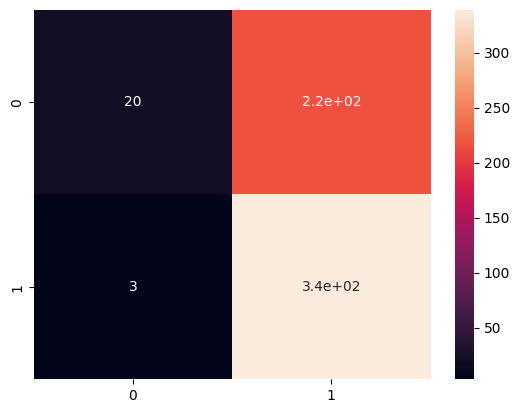

In [94]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot = True)